In [16]:
import numpy
import pandas as pd
# one-hot encoding categorical variables
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# for k-fold validation
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [4]:
df = pd.read_csv('AB_US_2020.csv')
df.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville


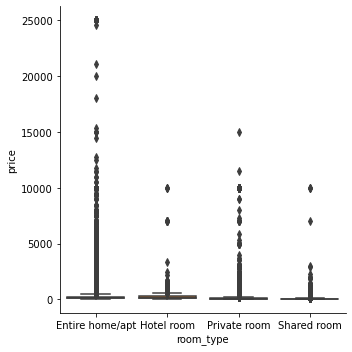

In [28]:
df['room_type'] = df['room_type'].astype('category')
sns.catplot(x='room_type', y='price', kind='box', data=df)

## One-Hot Encoding (Random Forest)

In [17]:
new_features = ['latitude', 'longitude','room_type','number_of_reviews','availability_365']
X = df[new_features]
y = df['price']

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[['room_type']]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[['room_type']]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(['room_type'], axis=1)
num_X_valid = X_valid.drop(['room_type'], axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [ ]:
print("RMSE from Approach 3 (One-Hot Encoding):") 
forest_model = RandomForestRegressor(n_estimators=500, random_state=1)
forest_model.fit(OH_X_train, y_train)

# get predicted prices on validation data
val_predictions = forest_model.predict(OH_X_valid)
print(mean_squared_error(y_valid, val_predictions, squared=False))

In [18]:
OH_X_train.head()

,latitude,longitude,number_of_reviews,availability_365,0,1,2,3
156400,40.65025,-73.96200,1,0,1.0,0.0,0.0,0.0
217144,44.84968,-93.49724,21,322,1.0,0.0,0.0,0.0
177906,37.34048,-121.89127,78,0,0.0,0.0,1.0,0.0
90983,33.85659,-118.18763,1,0,0.0,0.0,1.0,0.0
194386,37.79418,-122.40582,11,59,0.0,0.0,0.0,1.0


## Random Forest

In [22]:
features = ['latitude', 'longitude','number_of_reviews','availability_365']
X = df[features]
y = df['price']
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)

forest_model = RandomForestRegressor(n_estimators=500, random_state=1)
forest_model.fit(train_X, train_y)

# get predicted prices on validation data
val_predictions = forest_model.predict(val_X)
print("RMSE: ", mean_squared_error(val_y, val_predictions, squared=False))

RMSE:  521.9578320267169


In [20]:
print(len(train_X))
len(val_X)


169522


56508

In [18]:
val_X['val_Y'] = val_y
val_X['pred'] = val_predictions
val_X.head()

,latitude,longitude,number_of_reviews,availability_365,val_Y,pred
47143,39.77483,-105.01853,35,49,74,100.76
208534,47.52861,-122.28640,9,0,150,108.72
10355,30.21957,-97.96737,0,110,267,505.48
33845,41.79013,-87.63282,0,352,29,398.64
73275,33.84565,-118.19476,11,169,299,170.89


In [24]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, max_iter=1000).fit(OH_X_train, y_train)
predictions = regr.predict(OH_X_valid)
print("RMSE: " + str(mean_squared_error(predictions, y_valid, squared=False)))



RMSE: 577.0233587178686


### K-fold validation

In [ ]:
features = ['latitude', 'longitude','number_of_reviews','availability_365']
X = df[features]
y = df['price']

my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestRegressor(n_estimators=100,
                                                              random_state=0))
                             ])

from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_squared_error')
import math
for i, score in enumerate(scores):
    scores[i] = math.sqrt(score)
    
print("RMSE scores:\n", scores)
print(scores.mean())

# Introduction

This paper explores prediction of price of a U.S Airbnb listing. The dataset used is Kaggle's "U.S Airbnb Open Data".


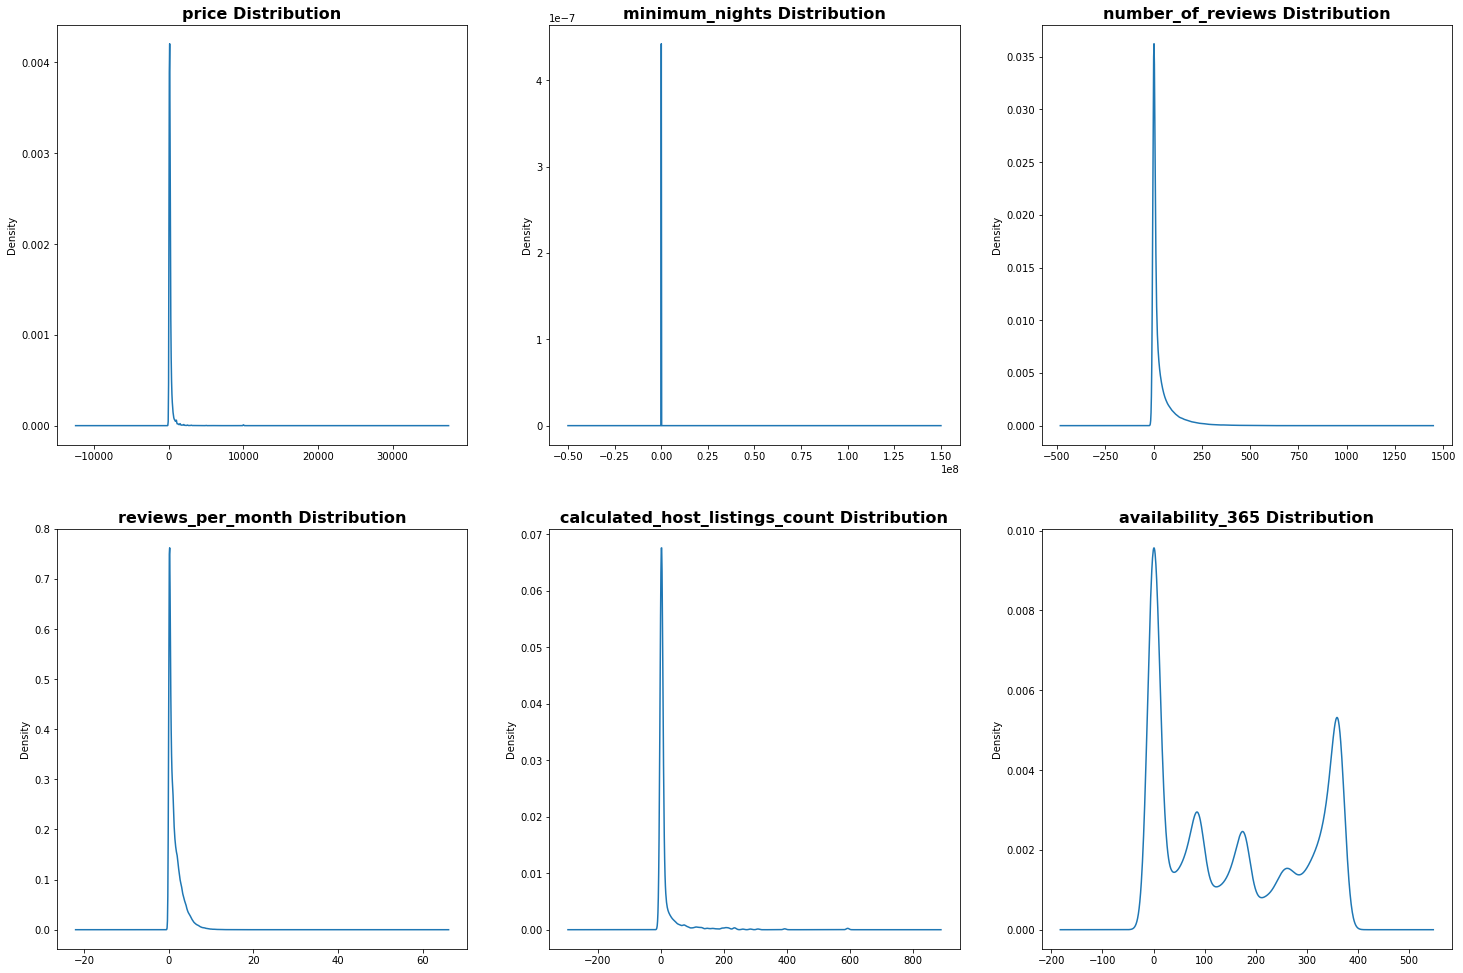

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(17)
fig.set_figwidth(25)
numerical_variables = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
current_col = 0
for row in axes:
    for col in row:
        df[numerical_variables[current_col]].plot(kind='density', ax=col)
        col.set_title(numerical_variables[current_col] +' Distribution',fontsize=16,fontweight='bold')
        current_col += 1

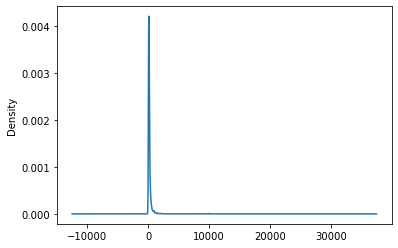

In [31]:
# Outlier Removal

upper_bound, lower_bound = 0.75, 0.25
iqr = df[df['price'].between(df['price'].quantile(lower_bound),df['price'].quantile(upper_bound), inclusive=True)]
iqr = iqr[iqr['number_of_reviews'] > 0]
iqr = iqr[iqr['calculated_host_listings_count'] < 10]
iqr = iqr[iqr['number_of_reviews'] < 200]
iqr = iqr[iqr['minimum_nights'] < 10]
iqr = iqr[iqr['reviews_per_month'] < 5]
df['price'].plot(kind='kde')

ValueError: plot kind scatter can only be used for data frames

# Citations

1) Kaggle Courses: "Introduction to Machine Learning" and "Intermediate Machine Learning". Code is referenced from here. 